In [13]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Activation Function

In [14]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [15]:
# Requires x to be the output of our sigmoid function
def sigmoidprime(x):
    return x * (1 - x)

## 2. Data Set

In [16]:
# define the input vector 
logical_gate_input = np.array([[0,0],[0,1],[1,0],[1,1]])

In [17]:
# define the 5 different label vectors using numpy's logical gates, such that they dynamically change when the inout is being altered
# *1 to transform the Boolean vector into an int vector of 0's and 1's
label_and = np.logical_and(logical_gate_input[:,0], logical_gate_input[:,1])*1
label_or = np.logical_or(logical_gate_input[:,0], logical_gate_input[:,1])*1
label_nand = np.logical_not(np.logical_and(logical_gate_input[:,0], logical_gate_input[:,1]))*1
label_nor = np.logical_not(np.logical_or(logical_gate_input[:,0], logical_gate_input[:,1]))*1
label_xor = np.logical_xor(logical_gate_input[:,0], logical_gate_input[:,1])*1

In [18]:
# Combining the labels for each gate
all_labels = [label_and, label_or, label_xor, label_nand, label_nor]

## 3. Perceptron

In [19]:
class Perceptron:
    """Single Perceptron with its input dimensionality, activation function, learning rate and weights"""
    
    def __init__(self, input_units, activation_function = sigmoid, learning_rate = 1):
        """Initialize a new Perceptron
        
        Arguments:
            input_units (int): Dimensionality of the input data.
            activation_function (function): To be applied activation function of the Perceptron.
                Set by default to the sigmoid function.
            learning_rate (float): Learning rate for a Learning Step.
                Set by default to 0.01
        """
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        
        # initialize random weights from a standard normal distribution for every input and one for the bias
        self.weights = np.random.randn(input_units + 1)
        
    def forward_step(self, inputs):
        """Perform a forward step for the Perceptron given a certain input by
            1. Calculating the weighted sum of inputs
            2. Applying the activation function
        
        Arguments:
            inputs (ndarray): Vector containing the input
            
        Returns:
            activation (float): calculated activation of the Perceptron 
        """
        # Calculating the drive and feeding it into the activation function
        # The weight of the bias is internally represented at the first position of the weight vector 
        drive = self.weights[1:] @ inputs + self.weights[0]
        activation = self.activation_function(drive)
        
        return activation
    
    def update(self, inputs, delta):
        """Update the current weights by delta according to the Perceptron´s learning rate
        
        Arguments:
            inputs (ndarray): Vector containing the input
            delta (float): error term 
        """
        # Prepend 1 to the inputs in order to add the activation of the bias 
        self.weights += self.learning_rate * delta * np.append(1, inputs)

## 3.5. Layers

In [36]:
class Layer:
    """Layer consisting of at least one Perceptron object"""
    
    def __init__(self, input_units, number_of_perceptrons, activation_function = sigmoid):
        """Initialize a new Layer
        
        Arguments:
            input_units (int): Dimensionality of the input values.
            number_of_perceptrons (int): Determines the size of the hidden layer.
            activation_function (function): To be applied activation function for the whole layer.
                Set by default to the sigmoid function.
        """
        # List comprehension for creating a list of perceptrons with given input dimensionality and activation function
        self.layersize = [Perceptron(input_units, activation_function) for _ in range(number_of_perceptrons)]
        
    def forward_step(self, inputs):
        """Perform a forward step for the whole layer by activating each perceptron individually
        
        Arguments:
            inputs (ndarray): Vector containing the input
            
        Returns:
            activation (ndarray): Vector containing the activations of each Perceptron in the layer 
        """
        return np.array([perceptron.forward_step(inputs) for perceptron in self.layersize])
    
    def update(self, inputs, delta_list):
        """Update the current weights of each Perceptron in the layer
        
        Arguments:
            inputs (ndarray): Vector containing the input
            delta (ndarray): Vector containing the error terms 
        """
        # Using zip to create a list of matching perceptron delta pairs
        for perceptron, delta in zip(self.layersize, delta_list):
            perceptron.update(inputs, delta)
    
    # Using the property decorator to implement a getter method (Otherwise it would only return the position of the array in our memory)
    @property
    def layer_weights(self):
        """Function to retrieve the weight vector of the respective layer 

        Returns:
            ndarray: All the weights for this perceptron layer.
        """
        return np.array([perceptron.weights for perceptron in self.layersize])
    

In [21]:
Layer?

Init signature:
Layer(
    input_units,
    number_of_perceptrons,
    activation_function=<function sigmoid at 0x7fd747b72c20>,
)
Docstring:      Layer consisting of at least one Perceptron object
Init docstring:
Initialize a new Layer

Arguments:
    input_units (int): Dimensionality of the input values.
    number_of_perceptrons (int): Determines the size of the hidden layer.
    activation_function (function): To be applied activation function for the whole layer.
        Set by default to the sigmoid function.
Type:           type
Subclasses:     


## 4. MLP

In [22]:
class MLP:
    """Multilayer Perceptron with at least 1 hidden layer and an output Perceptron"""
    
    # Using the asterisk operator to allow the creation of arbitrarily many layers
    def __init__(self, *layers):
        """Creates a multilayer perceptron with a given number of layers
        
        Arguments: 
            *layers: allows to create arbitary many perceptron layers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
        """
        self.number_of_layers = layers
    
    def forward_step(self, inputs):
        """Perform a forward step for the whole network by activating each layer individually

        Arguments:
            inputs (ndarray): Vector containing the input

        Returns:
            inputs (ndarray): activation of the network
        """
        # Propagate the input through the network
        for layer in self.number_of_layers:
            inputs = layer.forward_step(inputs)
            
        return inputs
        
    def backprop_step(self, inputs, labels):
        """Perform a step of the backpropagation algorithm
        
        Arguments:
            inputs (ndarray): Vector containing the input
            labels (ndarray): Vector containing the true labels to the input 
        """
        # Propagate the input through the network to save the intermediate results/outputs
        outputs = [inputs]
        for layer in self.number_of_layers:
            inputs = layer.forward_step(inputs)
            outputs.append(inputs)
        
        # The error at the output layer
        error = labels - outputs[-1] 

        # Backpropagation steps to calculate error signals (delta) for the perceptrons in the
        # hidden layers
        # As we only have the error for the outermost layer, we have to enumeratate the list in a
        # reversed order. Therefore we use the flip function.
        for layer, i in np.flip(list(enumerate(self.number_of_layers))):
            input_of_layer = outputs[i]
            output_of_layer = outputs[i+1]
            
            # We calculate the error signals (delta). 
            delta_list = sigmoidprime(output_of_layer) * error
            
            # We calculate the sum part of the error signal for each percetron in the previous layer.
            # We ignore the first entry, because it is only the error for the bias and not connected
            # to the layer that we are calculating the error signal for.
            # We have to transpose the weight matrix such that each row represent all outgoing weights
            # of one perceptron of the previous layer. Because the number of entries in each row has
            # to be equal to the number of entries in the delta array.
            error = (np.dot(layer.layer_weights.T, delta_list))[1:]
            layer.update(input_of_layer, delta_list)

## 5. Training

In [33]:
# Training the MLP.



# Initialize a MLP with one hidden layer consisting of 4 perceptrons and one output neuron.
mlp = MLP(Layer(2,4), Layer(4,1))

# Initialize lists to store steps, loss and performance.
steps = []
accuracies = []
losses = []

# Iterating over all gates in our label list in the following order: label_and, label_or, label_xor, label_nand & label_nor
for gate in all_labels:
    
    # The target we train the network on.
    t = gate

    # We train for 1000 epchos.
    for i in range(1000):
        steps.append(i)

        # 1. Draw a random sample from logical_gate_input and get the corresponding t
        index = np.random.randint(len(logical_gate_input))
        sample = logical_gate_input[index]
        label = t[index]

        # 2. Perform a training step
        mlp.backprop_step(sample, label)

        # Calculate the accuracy and loss over all four possible inputs
        accuracy_sum = 0
        loss_sum = 0
        for k in range(len(logical_gate_input)):
            # Feed each input into the mlp
            output = mlp.forward_step(logical_gate_input[k])  
             # This turns true if the output of the mlp, threshholded by 0.5, matches with the label
            accuracy_sum += int((output>0.5) == t[k]) 
            # Here we calculate the squared difference between the expected label (groundtruth) and the mlp's prediction
            loss_sum += (t[k]-output)**2
        # We divide through all the training examples
        accuracy = accuracy_sum / 4                
        accuracies.append(accuracy)
        loss = loss_sum / 4
        losses.append(loss)
    

## 6. Visualization

In [38]:
# We create two different figures such that every subplot is displayed approriately

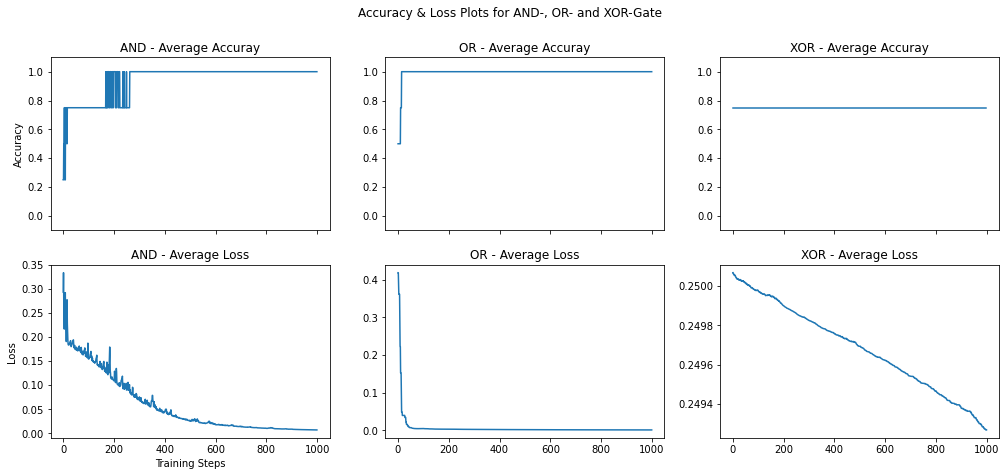

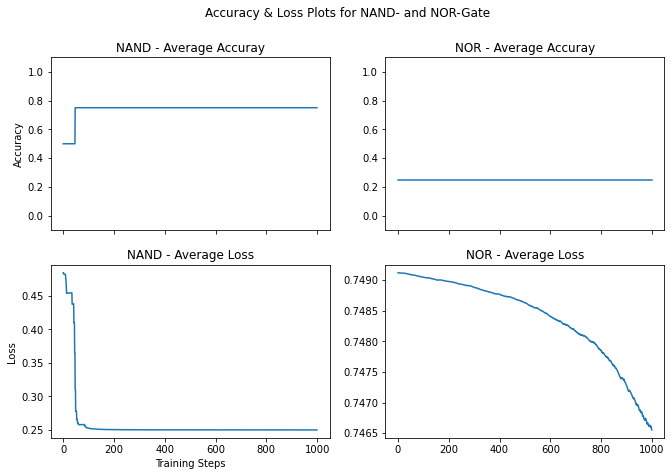

In [37]:
# Create 6 subplots, that share their x-axis  (training steps)
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex=True)
fig.set_figheight(7)
fig.set_figwidth(17)


# Since we need a 1000 samples for each gate and all samples are stored in a list (one for steps, one for accuracies and one for losses)
# we slice accordingly
# Plots for AND-Gate
axes[0,0].set(title="AND - Average Accuray", ylabel = "Accuracy", ylim = [-0.1, 1.1])
axes[1,0].set(title="AND - Average Loss", xlabel = "Training Steps", ylabel = "Loss")
axes[0,0].plot(steps[:1000], accuracies[:1000])
axes[1,0].plot(steps[:1000], losses[:1000])

# Plots for OR-Gate
axes[0,1].set(title="OR - Average Accuray", ylim = [-0.1, 1.1])
axes[1,1].set(title="OR - Average Loss")
axes[0,1].plot(steps[1000:2000], accuracies[1000:2000])
axes[1,1].plot(steps[1000:2000], losses[1000:2000])

# Plot for XOR-Gate
axes[0,2].set(title="XOR - Average Accuray", ylim = [-0.1, 1.1])
axes[1,2].set(title="XOR - Average Loss")
axes[0,2].plot(steps[2000:3000], accuracies[2000:3000])
axes[1,2].plot(steps[2000:3000], losses[2000:3000])

fig.suptitle("Accuracy & Loss Plots for AND-, OR- and XOR-Gate")
plt.show()



fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex=True)
fig.set_figheight(7)
fig.set_figwidth(11)

# Plots for NAND-Gate
axes[0,0].set(title="NAND - Average Accuray", ylabel = "Accuracy", ylim = [-0.1, 1.1])
axes[1,0].set(title="NAND - Average Loss", xlabel = "Training Steps", ylabel = "Loss")
axes[0,0].plot(steps[3000:4000], accuracies[3000:4000])
axes[1,0].plot(steps[3000:4000], losses[3000:4000])

# Plots for NOR-Gate
axes[0,1].set(title="NOR - Average Accuray", ylim = [-0.1, 1.1])
axes[1,1].set(title="NOR - Average Loss")
axes[0,1].plot(steps[4000:5000], accuracies[4000:5000])
axes[1,1].plot(steps[4000:5000], losses[4000:5000])

fig.suptitle("Accuracy & Loss Plots for NAND- and NOR-Gate")
plt.show()